### I cannot load CityScape dataset as they did not validate my account

In [18]:
# transform = T.Compose([ T.Resize((256, 512)), T.ToTensor()])
# input_transform = T.Compose([
#     T.Resize((256, 256)),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# target_transform = T.Compose([
#     T.Resize((256, 256)),
#     T.ToTensor()
# ])

# # Load the Cityscapes dataset
# dataset =Cityscapes('./data/cityscapes', split='train', mode='fine', target_type=['instance', 'color', 'polygon'])

# train_loader = DataLoader(cityscapes_train, batch_size=8, shuffle=True)
# val_loader = DataLoader(cityscapes_val, batch_size=8, shuffle=False)

In [19]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import Cityscapes
from torchvision.models.segmentation import fcn_resnet50
from torchvision.utils import make_grid

from torchvision.datasets import VOCSegmentation
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:

# Transforms
input_transform = T.Compose([ T.Resize((256, 256)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])
target_transform = T.Compose([ T.Resize((256, 256)), T.ToTensor() ])

# Load Pascal VOC dataset
# My initial plan was to use Cityscape Dataset but they took long time to validate my account
dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=input_transform, target_transform=target_transform)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [22]:
# Model
model = fcn_resnet50()
model.classifier[4] = nn.Conv2d(512, 21, kernel_size=1)  # Pascal VOC has 21 classes (20 classes + background)
model = model.to(device)

In [23]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).long().squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long().squeeze(1)
                outputs = model(inputs)['out']
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses

# Train the model
num_epochs = 25
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


100%|██████████| 128/128 [01:03<00:00,  2.03it/s]


Epoch 1/25, Train Loss: 0.3621, Val Loss: 0.1859


100%|██████████| 128/128 [01:02<00:00,  2.05it/s]


Epoch 2/25, Train Loss: 0.2008, Val Loss: 0.1823


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 3/25, Train Loss: 0.1941, Val Loss: 0.1824


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 4/25, Train Loss: 0.1916, Val Loss: 0.1710


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 5/25, Train Loss: 0.1869, Val Loss: 0.1767


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 6/25, Train Loss: 0.1853, Val Loss: 0.1728


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 7/25, Train Loss: 0.1831, Val Loss: 0.1690


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 8/25, Train Loss: 0.1791, Val Loss: 0.1826


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 9/25, Train Loss: 0.1835, Val Loss: 0.1761


100%|██████████| 128/128 [01:01<00:00,  2.06it/s]


Epoch 10/25, Train Loss: 0.1778, Val Loss: 0.1737


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 11/25, Train Loss: 0.1757, Val Loss: 0.1810


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 12/25, Train Loss: 0.1769, Val Loss: 0.1838


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 13/25, Train Loss: 0.1679, Val Loss: 0.1841


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 14/25, Train Loss: 0.1701, Val Loss: 0.1744


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 15/25, Train Loss: 0.1586, Val Loss: 0.1731


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 16/25, Train Loss: 0.1621, Val Loss: 0.1757


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 17/25, Train Loss: 0.1570, Val Loss: 0.1753


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 18/25, Train Loss: 0.1575, Val Loss: 0.1718


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 19/25, Train Loss: 0.1525, Val Loss: 0.1841


100%|██████████| 128/128 [01:01<00:00,  2.06it/s]


Epoch 20/25, Train Loss: 0.1479, Val Loss: 0.1762


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 21/25, Train Loss: 0.1392, Val Loss: 0.1838


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 22/25, Train Loss: 0.1274, Val Loss: 0.1777


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


Epoch 23/25, Train Loss: 0.1231, Val Loss: 0.1929


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 24/25, Train Loss: 0.1380, Val Loss: 0.2865


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


Epoch 25/25, Train Loss: 0.1331, Val Loss: 0.1834


In [24]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_pixels = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long().squeeze(1)
            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_pixels += labels.numel()

    avg_loss = running_loss / len(test_loader.dataset)
    accuracy = correct_predictions.double() / total_pixels

    return avg_loss, accuracy

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.1571, Test Accuracy: 95.17%


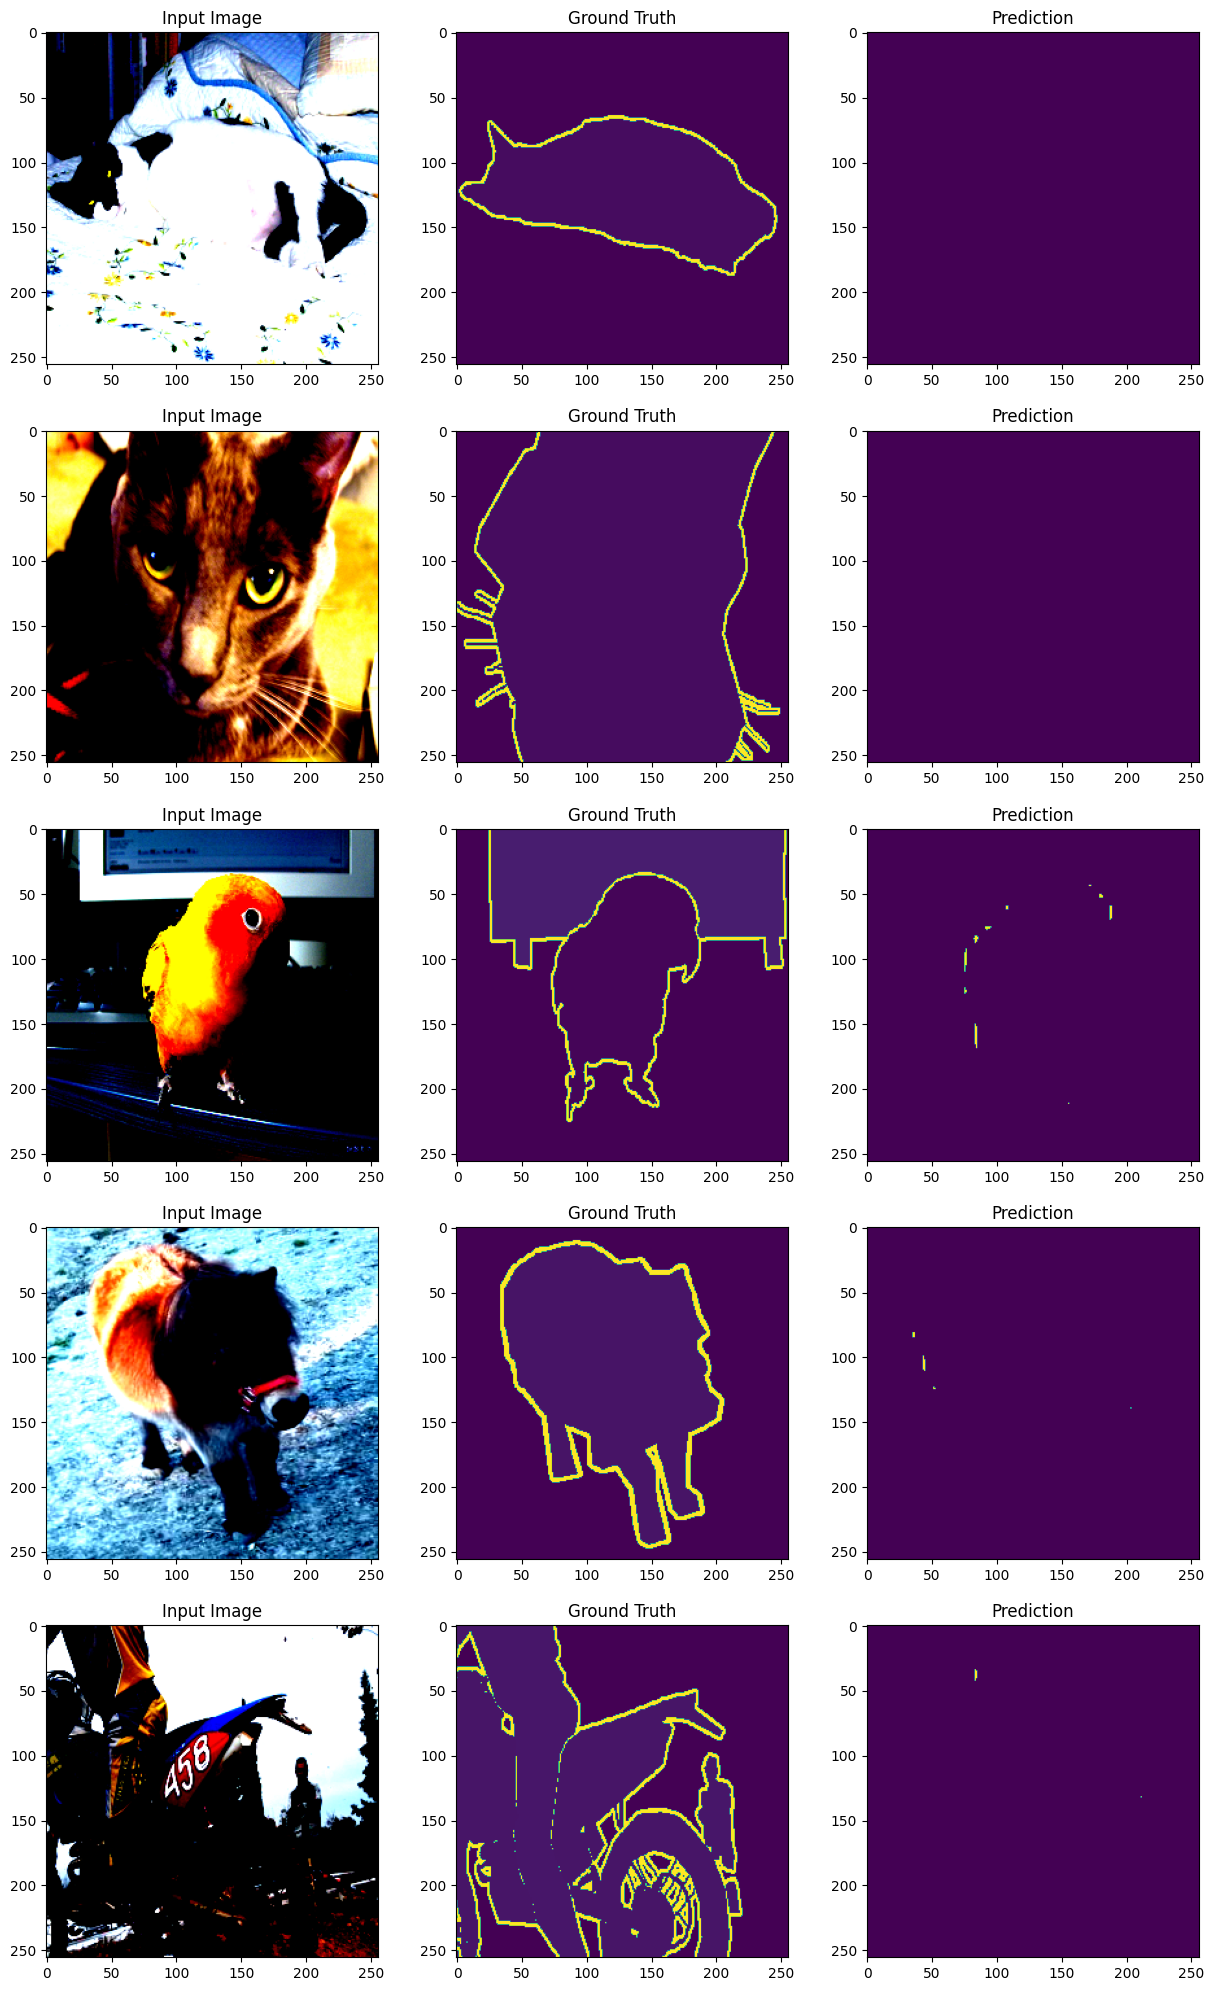

In [50]:
# Visualize predictions
def visualize_predictions(model, dataset, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        image = image.to(device).unsqueeze(0)
        outputs = model(image)['out']
        image = image.squeeze().cpu().permute(1, 2, 0).numpy()
        label = label.squeeze().cpu().numpy()
        pred_mask = torch.argmax(outputs, dim=1).cpu().squeeze().numpy()

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Input Image')
        axes[i, 1].imshow(label)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 2].imshow(pred_mask)
        axes[i, 2].set_title('Prediction')

    plt.show()

# Visualize predictions
visualize_predictions(model, dataset)

In [4]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.encoder = fcn_resnet50().backbone
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Upsample to match target size
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True), # Add upsampling layer

            nn.Conv2d(512, n_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)['out']
        x = self.decoder(x)
        return x

n_classes = 21  # Number of classes in the Cityscapes dataset
model = UNet(n_classes).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


In [5]:
# # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# # Training loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, targets in loader:
        images = images.to(device)
        #this step was suggested by collab fix error AI
        targets = targets.to(device).long().squeeze(1) # squeeze the target to remove the extra dimension

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

# # Validation loop
def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device).long().squeeze(1) # squeeze the target to remove the extra dimension


            outputs = model(images)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [7]:
num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/25, Train Loss: 0.7775, Val Loss: 0.2063
Epoch 2/25, Train Loss: 0.2062, Val Loss: 0.2029
Epoch 3/25, Train Loss: 0.1977, Val Loss: 0.1929
Epoch 4/25, Train Loss: 0.1948, Val Loss: 0.1957
Epoch 5/25, Train Loss: 0.1878, Val Loss: 0.1931
Epoch 6/25, Train Loss: 0.1866, Val Loss: 0.1905
Epoch 7/25, Train Loss: 0.1846, Val Loss: 0.1960
Epoch 8/25, Train Loss: 0.1921, Val Loss: 0.1988
Epoch 9/25, Train Loss: 0.1878, Val Loss: 0.1969
Epoch 10/25, Train Loss: 0.1914, Val Loss: 0.2241
Epoch 11/25, Train Loss: 0.1944, Val Loss: 0.1954
Epoch 12/25, Train Loss: 0.1906, Val Loss: 0.1965
Epoch 13/25, Train Loss: 0.1833, Val Loss: 0.2037
Epoch 14/25, Train Loss: 0.1881, Val Loss: 0.1931
Epoch 15/25, Train Loss: 0.1875, Val Loss: 0.1849
Epoch 16/25, Train Loss: 0.1874, Val Loss: 0.1896
Epoch 17/25, Train Loss: 0.1857, Val Loss: 0.1904
Epoch 18/25, Train Loss: 0.1796, Val Loss: 0.1853
Epoch 19/25, Train Loss: 0.1773, Val Loss: 0.1826
Epoch 20/25, Train Loss: 0.1756, Val Loss: 0.1830
Epoch 21/

In [15]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device).long().squeeze(1) # squeeze the target to remove the extra dimension

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.nelement()
            correct += (predicted == targets).sum().item()

    return correct / total

pixel_accuracy = evaluate(model, val_loader, device)
print(f"Pixel Accuracy: {pixel_accuracy * 100:.2f}%")

Pixel Accuracy: 94.43%


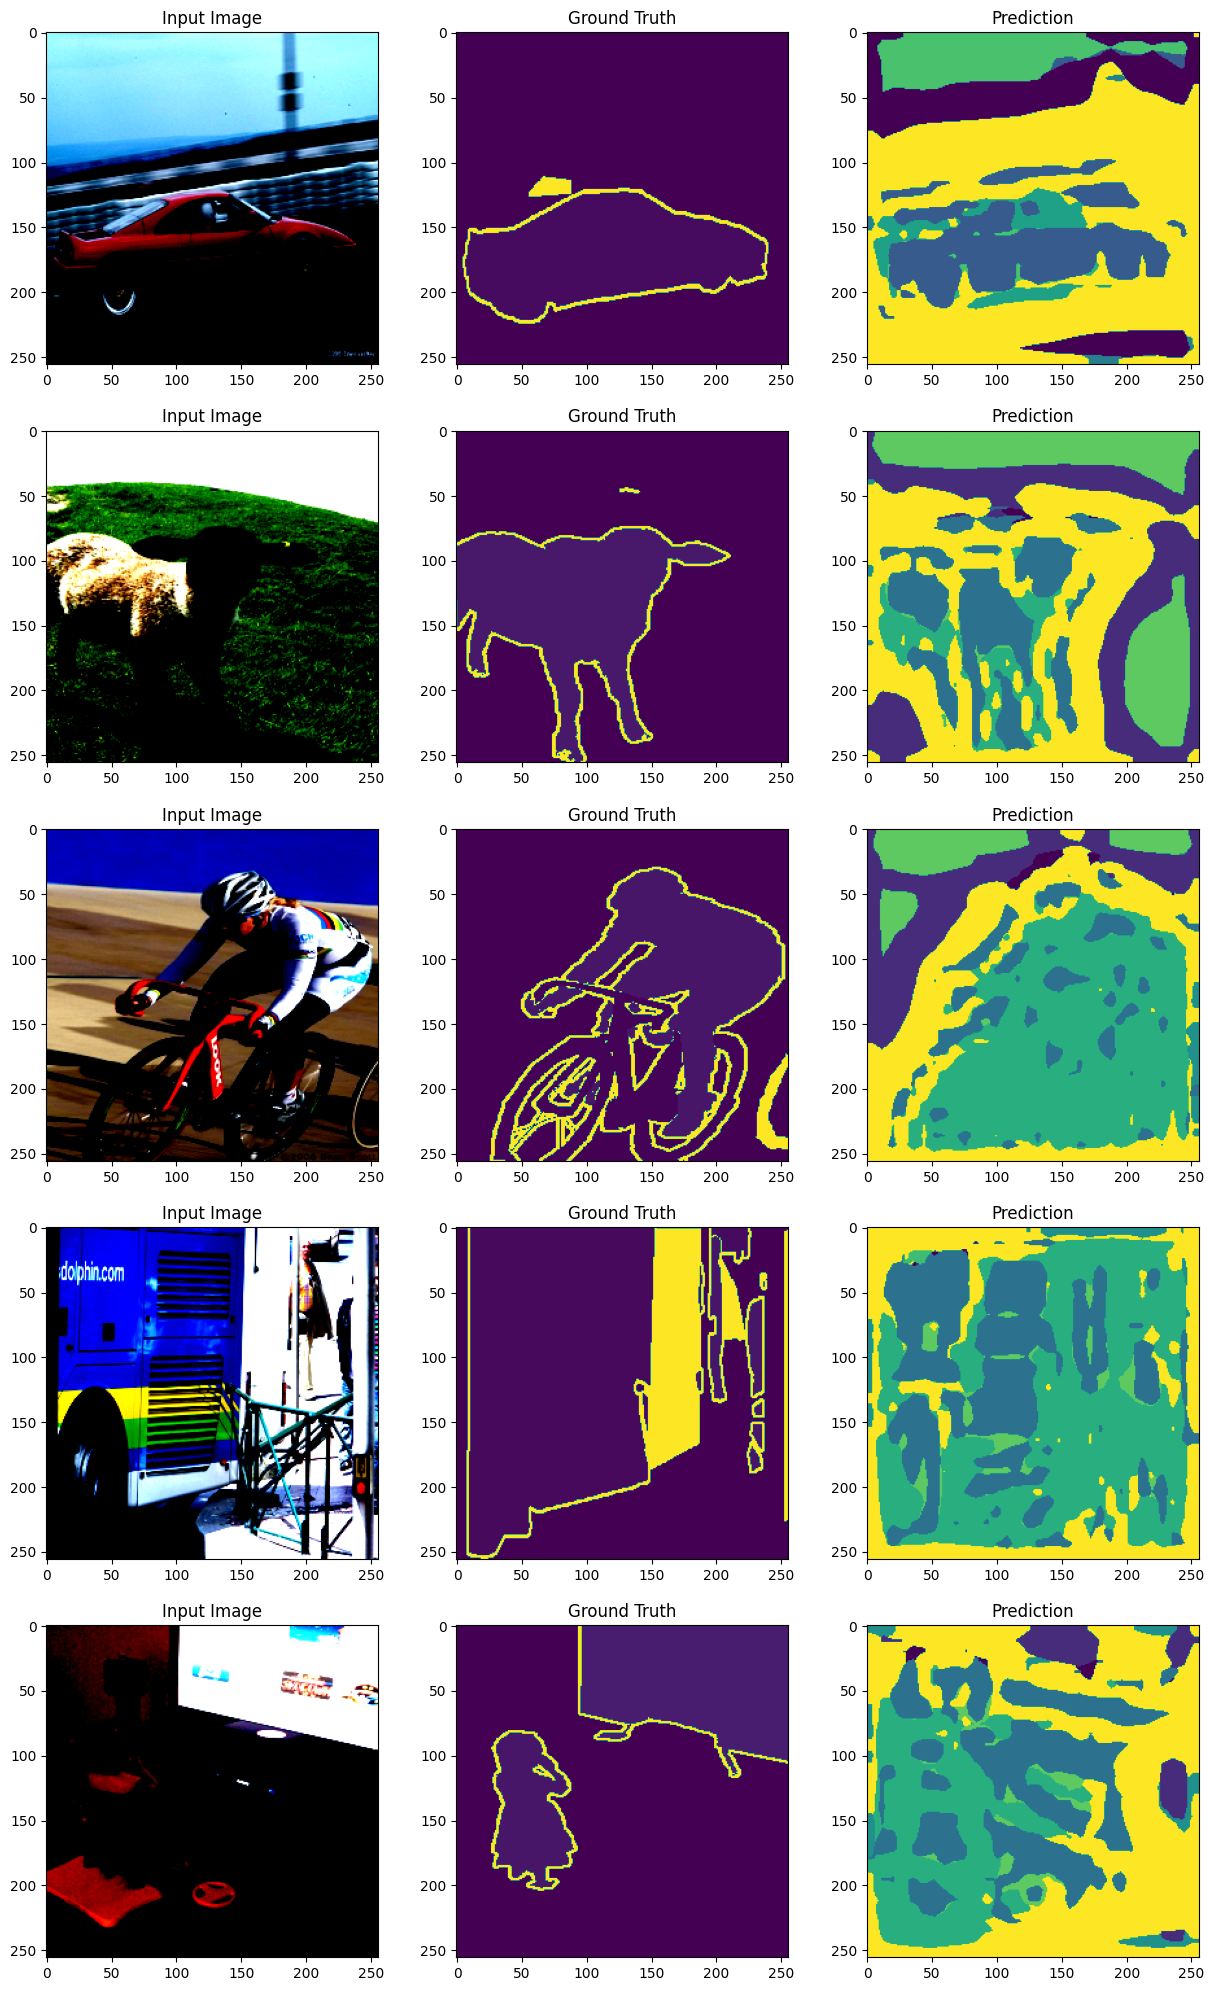

In [48]:
# Visualize predictions
visualize_predictions(model, dataset)